<a href="https://colab.research.google.com/github/DenisVasil/Keras_2023/blob/main/KerasCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

In [ ]:
images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255)(images)

In [ ]:
images.shape

TensorShape([2, 70, 120, 3])

In [ ]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 64, 114, 32])

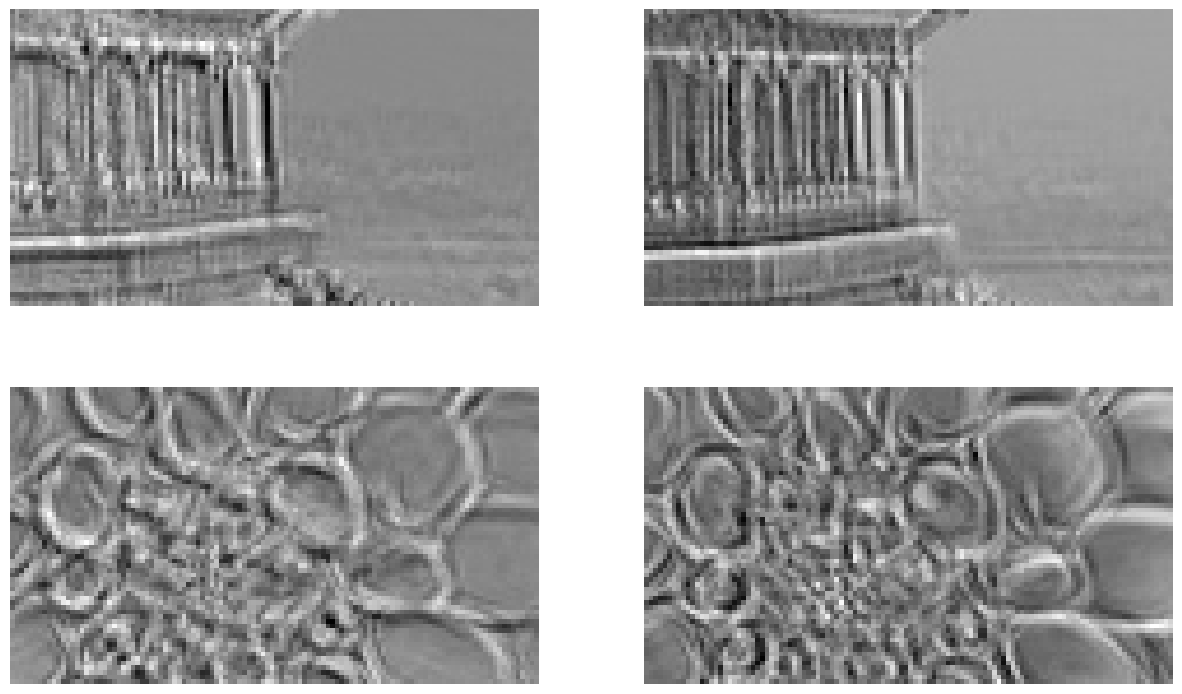

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [ ]:
#zero padding
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [ ]:
# the output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [ ]:
import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

In [ ]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [ ]:
biases.shape

(32,)

In [ ]:
tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

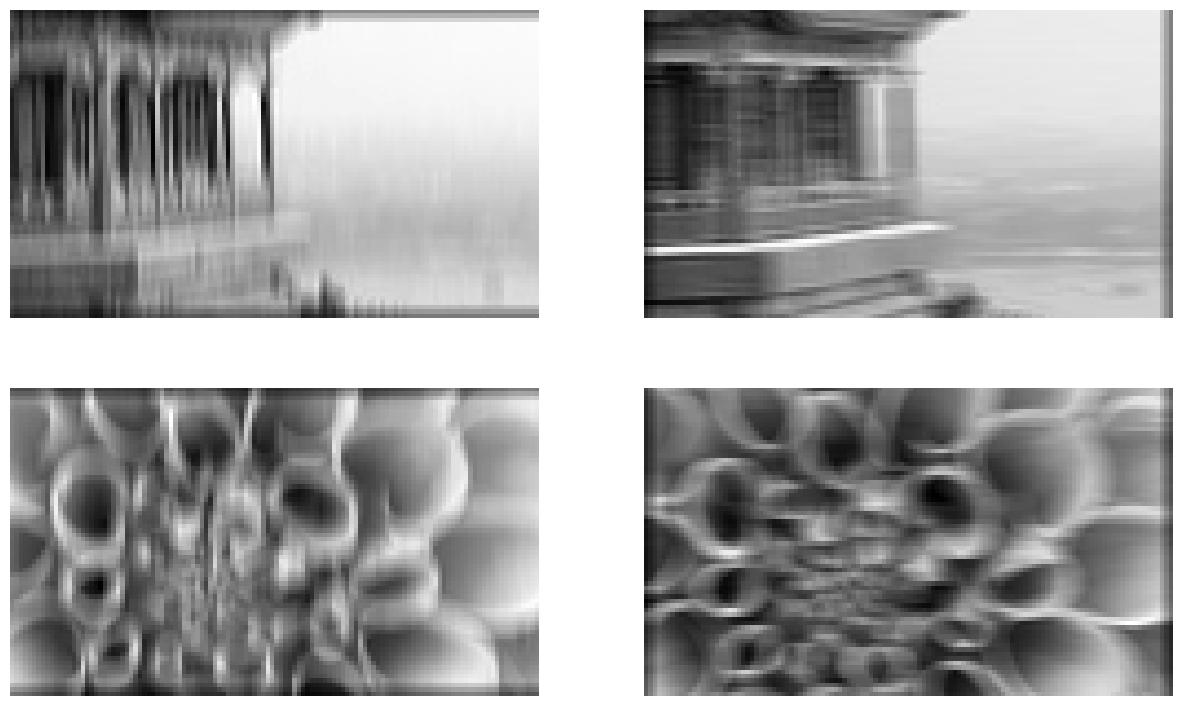

In [ ]:
# manually create two filters

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [ ]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [ ]:
output = max_pool(images)

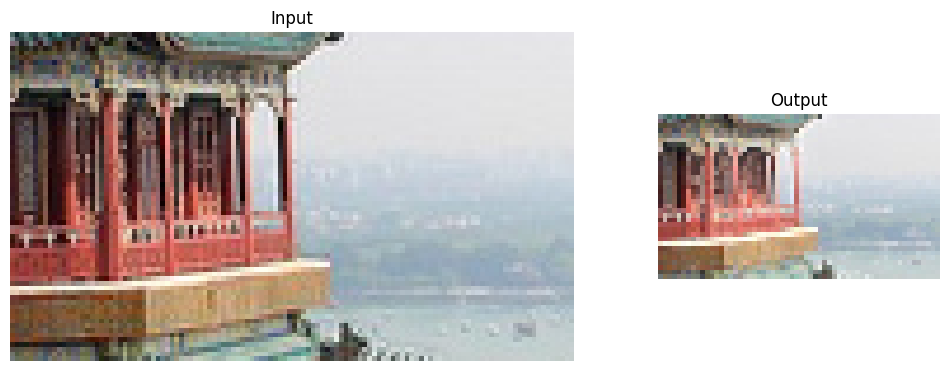

In [ ]:
import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [ ]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

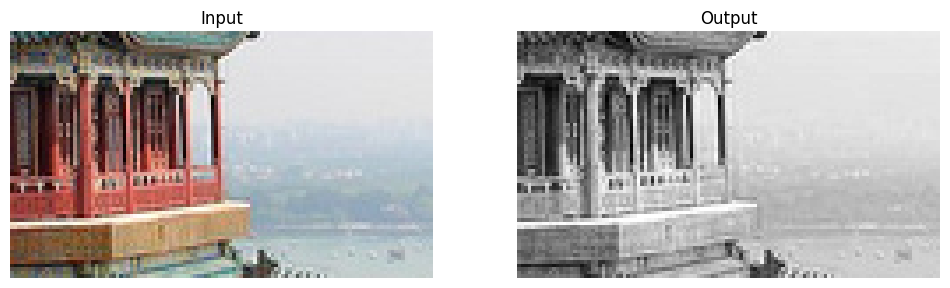

In [ ]:
# computes and displays the output of the depthwise pooling layer
depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

In [ ]:
# raw average poolinging
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

In [ ]:
# global average poolinging in keras
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [ ]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.26010972, 0.10848834]], dtype=float32)>

# CNNs

In [ ]:
import numpy as np

mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
tf.random.set_seed(42)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(120, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(120, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax"),
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2,
                                                     restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/100
1719/1719 [==============================] - 19s 9ms/step - loss: 0.6828 - accuracy: 0.7604 - val_loss: 0.3917 - val_accuracy: 0.8578
Epoch 2/100
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4067 - accuracy: 0.8596 - val_loss: 0.3112 - val_accuracy: 0.8880
Epoch 3/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3497 - accuracy: 0.8813 - val_loss: 0.2928 - val_accuracy: 0.8906
Epoch 4/100
1719/1719 [==============================] - 15s 8ms/step - loss: 0.3136 - accuracy: 0.8944 - val_loss: 0.2770 - val_accuracy: 0.9006
Epoch 5/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2872 - accuracy: 0.9018 - val_loss: 0.2549 - val_accuracy: 0.9086
Epoch 6/100
1719/1719 [==============================] - 15s 8ms/step - loss: 0.2665 - accuracy: 0.9089 - val_loss: 0.2577 - val_accuracy: 0.9046
Epoch 7/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2508 - accuracy: 0.9135 - val_loss: 0.2656 

In [ ]:
score = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.2755 - accuracy: 0.9043


In [ ]:
X_new = X_test[:10]
y_pred = model.predict(X_new)

1/1 [==============================] - 0s 94ms/step


In [ ]:
y_pred.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.95, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.1 , 0.  , 0.88, 0.  , 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ]],
      dtype=float32)

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
y_pred_c = y_pred.argmax(axis=-1)
y_pred_c

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [ ]:
np.array(class_names)[y_pred_c]

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser',
       'Coat', 'Shirt', 'Sandal', 'Sneaker'], dtype='<U11')

# Transfer learning with Keras

## Using pretrained models

In [ ]:
import tensorflow as tf
model = tf.keras.applications.ResNet50(weights="imagenet")

In [ ]:
from sklearn.datasets import load_sample_images
images = load_sample_images()["images"]

In [ ]:
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

In [ ]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [ ]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 [==============================] - 9s 9s/step


(2, 1000)

In [ ]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
top_K

[[('n03877845', 'palace', 0.5469369),
  ('n03781244', 'monastery', 0.2471462),
  ('n02825657', 'bell_cote', 0.18550403)],
 [('n04522168', 'vase', 0.32669598),
  ('n11939491', 'daisy', 0.17817341),
  ('n03530642', 'honeycomb', 0.12041592)]]

In [ ]:
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.71%
  n02825657 - bell_cote    18.55%
Image #1
  n04522168 - vase         32.67%
  n11939491 - daisy        17.82%
  n03530642 - honeycomb    12.04%


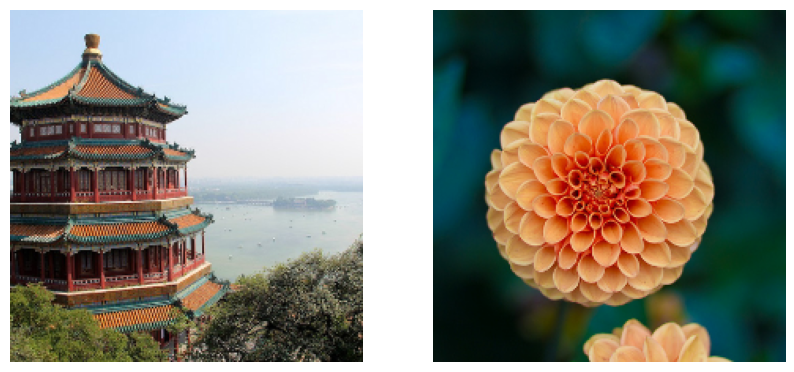

In [ ]:
# cropped and resized images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

# Pretrained Models for Transfer Learning

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [2]:
dataset_size

3670

In [3]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [4]:
n_classes

5

In [5]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

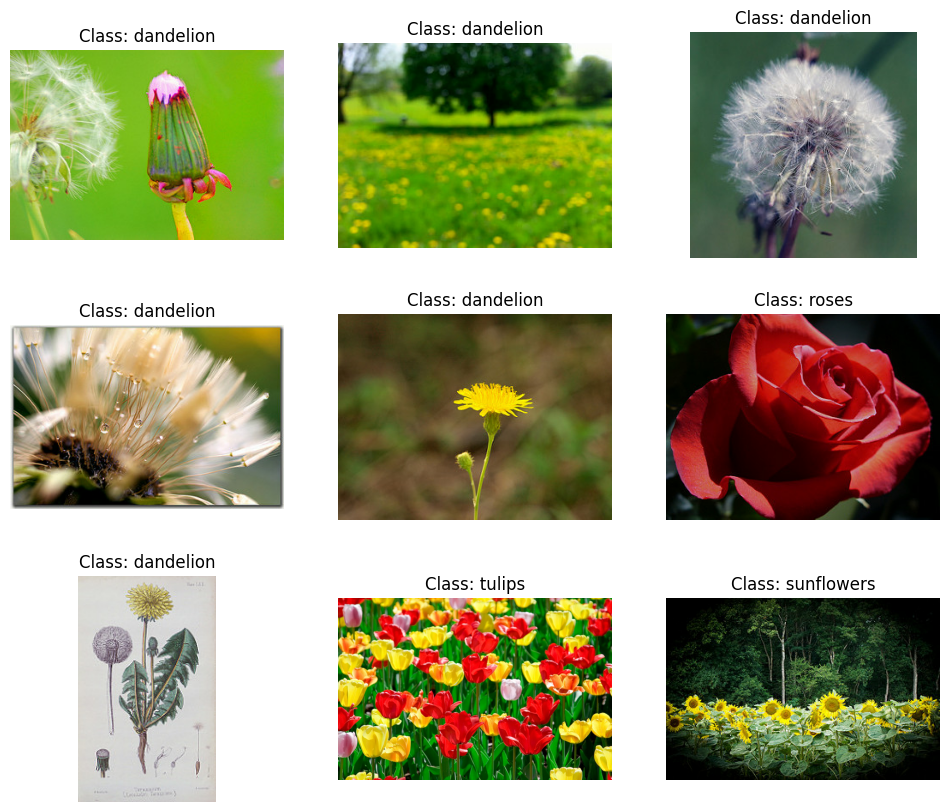

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

In [8]:
# All three datasets contain individual images. They need to be batched,
# but for this they all have to have the same size.
# Resizing layer can be used for this.
# Also tf.keras.applications.xception.preprocess_input() function
# has to be called to preprocess the images appropriately for the Xception model.
# Shuffling and prefetching will be added to the training dataset.

tf.keras.backend.clear_session()  # resets layer name counter
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

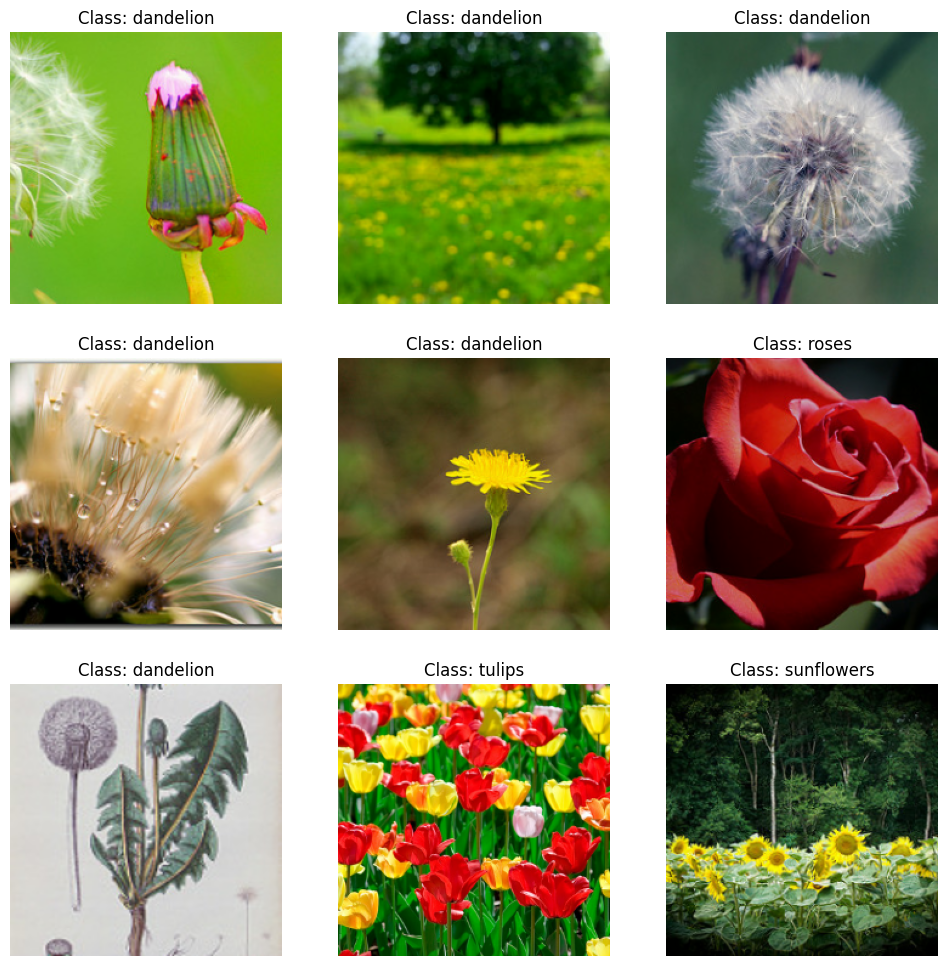

In [9]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed = 42),
    tf.keras.layers.RandomContrast(factor=0.2, seed = 42)
])

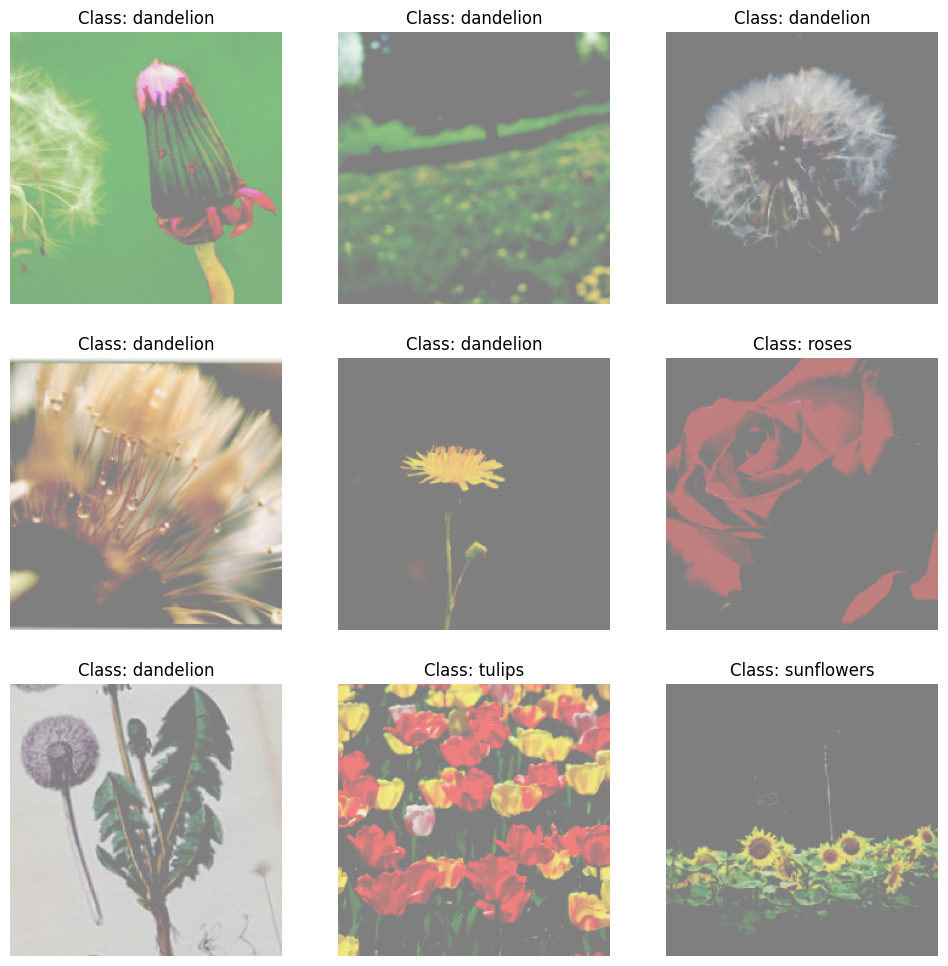

In [17]:
# displays the same first 9 images, after augmentation
import numpy as np

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [18]:
tf.random.set_seed(42)

base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs = base_model.input, outputs = output)

83683744/83683744 [==============================] - 3s 0us/step


In [20]:
for layer in base_model.layers:
  layer.trainable = False

We exclude the top of the network by setting include_top=False:
this excludes the global average pooling layer and the dense output layer. We then add our own global average pooling layer, based on the output of the base model, followed by a dense output layer with one unit per class, using the softmax activation function. Finally, we create the Keras Model

In [22]:
from keras.optimizers import optimizer
# training the model for a few epochs, while keeping the base model weights fixed

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history= model.fit(train_set, validation_data = valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 29s 175ms/step - loss: 0.7084 - accuracy: 0.8085 - val_loss: 0.6486 - val_accuracy: 0.8475
Epoch 2/3
86/86 [==============================] - 15s 159ms/step - loss: 0.3118 - accuracy: 0.9095 - val_loss: 0.5487 - val_accuracy: 0.8657
Epoch 3/3
86/86 [==============================] - 15s 159ms/step - loss: 0.1987 - accuracy: 0.9360 - val_loss: 0.5381 - val_accuracy: 0.8730


In [23]:
# now we can make the top part of the base model trainable again,
# and continue training, but with a lower learning rate:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history= model.fit(train_set, validation_data = valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 39s 299ms/step - loss: 0.2638 - accuracy: 0.9142 - val_loss: 0.6033 - val_accuracy: 0.8475
Epoch 2/10
86/86 [==============================] - 26s 297ms/step - loss: 0.0673 - accuracy: 0.9804 - val_loss: 0.3733 - val_accuracy: 0.9020
Epoch 3/10
86/86 [==============================] - 27s 302ms/step - loss: 0.0154 - accuracy: 0.9953 - val_loss: 0.3107 - val_accuracy: 0.9111
Epoch 4/10
86/86 [==============================] - 27s 305ms/step - loss: 0.0060 - accuracy: 0.9985 - val_loss: 0.3187 - val_accuracy: 0.9074
Epoch 5/10
86/86 [==============================] - 27s 307ms/step - loss: 0.0105 - accuracy: 0.9964 - val_loss: 0.3325 - val_accuracy: 0.9111
Epoch 6/10
86/86 [==============================] - 28s 308ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.3150 - val_accuracy: 0.9147
Epoch 7/10
86/86 [==============================] - 27s 311ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.3282 - val_accuracy: 0.9111

In [24]:
score = model.evaluate(test_set)

12/12 [==============================] - 4s 257ms/step - loss: 0.2662 - accuracy: 0.9264
